# Notebook Test

## Agent Initialization

Since the agent will be used across multiple blocks, we need to initialize it once at the beginning to avoid unintentionally initializing it multiple times.

In [1]:
# from agent import ... # Ton agent local

# agent = ToolAgent(model="phi3:instruct")
# agent = ...

## Questions Data from the GAIA dataset

In this section, we import questions from the GAIA dataset and extract information about which tools are used in each question. This allows us to prioritize the implementation of the most relevant tools.


### Import

In [2]:
import json 

with open('data/metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

json_QA_level1 = [item for item in json_QA if str(item.get("Level", "")) == "1"]


### Metadatas about one question

In [3]:
import random
# random.seed(42)
random_samples = random.sample(json_QA, 20)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: 9b54f9d9-35ee-4a14-b62f-d130ea00317f
Question: Which of the text elements under CATEGORIES in the XML would contain the one food in the spreadsheet that does not appear a second time under a different name?
Level: 3
Final Answer: Soups and Stews
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Open the spreadsheet.
  │      ├── 2. Go through each item, eliminating ones that have duplicates under a different name (e.g. clam = geoduck, sandwich = hoagie, dried cranberries = craisins...).
  │      ├── 3. (Optional) Look up any unrecognizable food names.
  │      ├── 4. Note the remaining unique food (turtle soup).
  │      ├── 5. Open the XML.
  │      ├── 6. Find the CATEGORIES label.
  │      ├── 7. Note the matching text element for the food (Soups and Stews).
  ├── Number of steps: 7
  ├── How long did this take?: 15 minutes
  ├── Tools:
  │      ├── 1. Excel file access
  │      ├── 2. XML file access
  │      ├── 3. (Optional) Web browser
  │      ├── 4. (Optional) Search

### Used tools summary

In [4]:
# list of the tools used in all the samples
from collections import Counter, OrderedDict

tools = []
for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        tool = tool[2:].strip().lower()
        if tool.startswith("("):
            tool = tool[11:].strip()
        tools.append(tool)
tools_counter = OrderedDict(Counter(tools))
print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))
for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

## Creation of a database

### First step : Build it



🔽 Initialize Hugging Face embeddings and connect to Supabase using environment variables. 🔽


In [5]:
import os
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore
from supabase.client import Client, create_client


load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

🔽 Convert QA pairs into vectorized documents and upload them to a Supabase table for retrieval. 🔽 

This is an example of how to do it automatically but you may have to do it manually.

Moreover, there is some functions to create directly on Supabase. Follow this guide : https://python.langchain.com/docs/integrations/vectorstores/supabase/


In [6]:

# wrap the metadata.jsonl's questions and answers into a list of document
from langchain.schema import Document
docs = []
for sample in json_QA:
    content = f"Question : {sample['Question']}\n\nFinal answer : {sample['Final answer']}"
    doc = {
        "content" : content,
        "metadata" : { # meatadata的格式必须时source键，否则会报错
            "source" : sample['task_id']
        },
        "embedding" : embeddings.embed_query(content),
    }
    docs.append(doc)

# upload the documents to the vector database
try:
    response = (
        supabase.table("GAIA")
        .insert(docs)
        .execute()
    )
except Exception as exception:
    print("Error inserting data into Supabase:", exception)


# ALTERNATIVE : Save the documents (a list of dict) into a csv file, and manually upload it to Supabase
import pandas as pd
df = pd.DataFrame(docs)
df.to_csv('supabase_docs.csv', index=True)


Error inserting data into Supabase: {'message': 'JSON could not be generated', 'code': 404, 'hint': 'Refer to full message for details', 'details': "b'{}'"}


🔽 Connect to the Supabase vector store and expose it as a retriever for similarity search. 🔽


In [7]:
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding=embeddings,
    table_name="GAIA",
    query_name="match_documents",
)
retriever = vector_store.as_retriever()

### Second step : Testing the database and the retriever

In [8]:
query = "On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?"
matched_docs = vector_store.similarity_search(query, 2)
docs = retriever.invoke(query)
docs[0]

Document(metadata={'source': '840bfca7-4f7b-481a-8794-c560c340185d'}, page_content='Question : On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?\n\nFinal answer : 80GSFC21M0002')

## Creating the prompt

For a nice prompt, we need some examples questions

In [9]:
system_prompt = """
You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
==========================
Here is a few examples showing you how to answer the question step by step.
"""
for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"
system_prompt += "\n==========================\n"
system_prompt += "Now, please answer the following question step by step.\n"

# save the system_prompt to a file
with open('system_prompt.txt', 'w') as f:
    f.write(system_prompt)


In [10]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
Here is a few examples showing you how to answer the question step by step.

Question 1: Which of the text elements under CATEGORIES in the XML would contain the one food in the spreadsheet that does not appear a second time under a different name?
Steps:
1. Open the spreadsheet.
2. Go through each item, eliminating ones that have duplicates under a different name (e.g. clam = geoduck, sandwich = hoagie, dried cranberries = craisins...).
3. (Optional) Look up any unrecognizable food names.
4. Note the remaining unique food (turtle soup).
5. Open the XML.
6. Find the CATEGORIES label.
7. Note the matching text element for the food (Soups and Stews).
Tools:
1. Excel file access
2. XML file acce

## Tools

Because to better perform you must have access to tools

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.document_loaders import ArxivLoader
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers.
    
    Args:
        a: first int
        b: second int
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

@tool
def modulus(a: int, b: int) -> int:
    """Get the modulus of two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a % b

@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for a query and return maximum 2 results.
    
    Args:
        query: The search query."""
    search_docs = WikipediaLoader(query=query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"wiki_results": formatted_search_docs}

@tool
def web_search(query: str) -> str:
    """Search Tavily for a query and return maximum 3 results.
    
    Args:
        query: The search query."""
    search_docs = TavilySearchResults(max_results=3).invoke(query=query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return {"web_results": formatted_search_docs}

@tool
def arvix_search(query: str) -> str:
    """Search Arxiv for a query and return maximum 3 result.
    
    Args:
        query: The search query."""
    search_docs = ArxivLoader(query=query, load_max_docs=3).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
            for doc in search_docs
        ])
    return {"arvix_results": formatted_search_docs}



question_retrieve_tool = create_retriever_tool(
    vector_store.as_retriever(),
    "Question Retriever",
    "Find similar questions in the vector database for the given question.",
)

@tool
def similar_question_search(question: str) -> str:
    """Search the vector database for similar questions and return the first results.
    
    Args:
        question: the question human provided."""
    matched_docs = vector_store.similarity_search(query, 3)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
            for doc in matched_docs
        ])
    return {"similar_questions": formatted_search_docs}

tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arvix_search,
    similar_question_search
]

## Graph 

Now we have all the tools we needed. Let's create the graph and the agent

In [12]:
from dotenv import load_dotenv
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFaceEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage


# System message
sys_msg = SystemMessage(content=system_prompt)

def build_graph(provider: str = "groq"):
    """Build the LangGraph reasoning agent"""

    # 1. Sélection du LLM en fonction du provider
    if provider == "google":
        llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
    elif provider == "groq":
        llm = ChatGroq(model="qwen-qwq-32b", temperature=0)
    elif provider == "huggingface":
        llm = ChatHuggingFace(
            llm=HuggingFaceEndpoint(
                url="https://api-inference.huggingface.co/models/Meta-DeepLearning/llama-2-7b-chat-hf",
                temperature=0,
            )
        )
    else:
        raise ValueError("Invalid provider. Choose 'google', 'groq' or 'huggingface'.")

    # 2. Association des outils au LLM
    llm_with_tools = llm.bind_tools(tools)

    # 3. Définition des noeuds LangGraph

    def assistant(state: MessagesState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
    def retriever(state: MessagesState):
        similar_question = vector_store.similarity_search(state["messages"][0].content)
        example_msg = HumanMessage(
            content=f"Here is a similar Q&A for context:\n\n{similar_question[0].page_content}",
        )
        return {"messages": [sys_msg] + state["messages"] + [example_msg]}

    # 4. Construction du graphe LangGraph
    builder = StateGraph(MessagesState)
    builder.add_node("retriever", retriever)
    builder.add_node("assistant", assistant)
    builder.add_node("tools", ToolNode(tools))

    builder.add_edge(START, "retriever")
    builder.add_edge("retriever", "assistant")
    builder.add_conditional_edges("assistant", tools_condition)
    builder.add_edge("tools", "assistant")

    return builder.compile()

graph = build_graph(provider="groq")


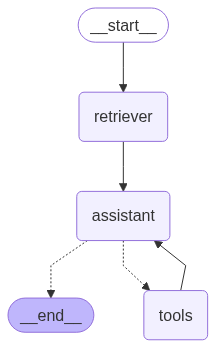

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
question = ""
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages})



In [15]:
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================


================================ System Message ================================


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
Here is a few examples showing you how to answer the question step by step.

Question 1: Which of the text elements under CATEGORIES in the XML would contain the one food in the spreadsheet that does not appear a second time under a different name?
Steps:
1. Open the spreadsheet.
2. Go through each item, eliminating ones that have duplicates under a different name (e.g. clam = geoduck, sandwich = hoagie, dried cranberries = craisins...).
3. (Optional) Look up any unrecognizable food names.
4. Note the remaining unique food (turtle